# Example of using the Reversible-Jump Markov Chain Monte Carlo algorithm on some noisy data

The Data Science Research theme members of the Research School of Earth Sciences, The Australian National University.

9 November 2017

Please see the publication:

1.Sambridge, M., Gallagher, K., Jackson, A. & Rickwood, P. Trans-dimensional inverse problems, model comparison and the evidence. Geophysical Journal International 167, 528–542 (2006).

for details about trans-dimentional fitting and the use of the RJ-MCMC. See the iEarth website (http://www.iearth.org.au/) to get access to RJ-MCMC.

Jupyter Notebook written from the examples and documentation of RJ-MCMC.

For questions/errors, contact: [Charles Le Losq](mailto:charles.lelosq@anu.edu.au)

## The libraries that we need


In [1]:
# need to be in first position
%matplotlib inline 

# matplotlib library and stuff needed for plots
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc


# For calculations
import rjmcmc 
import numpy as np # not really necessary as rjmcmc does not handle numpy arrays
import random
import math

## Data Generation

We create some fake data that we can play with, using an interesting mathematical function that will require
some higher order polynomial to fit.

Text(0.5,1,u'Figure 1: our noisy observation...')

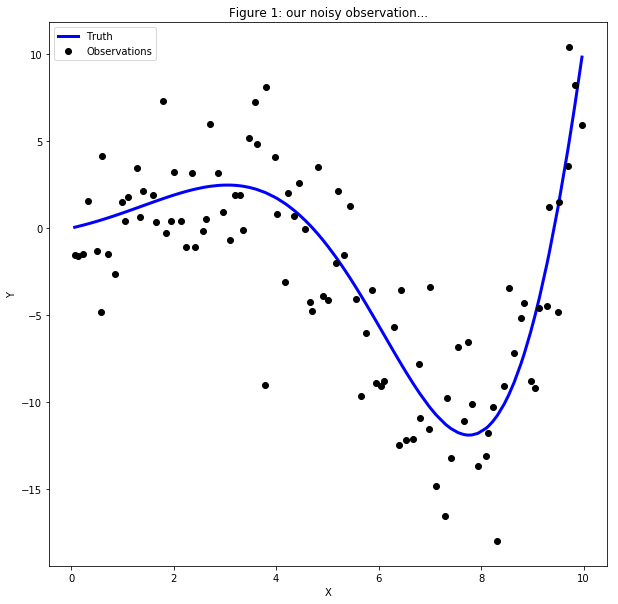

In [2]:
# The function givin us the truth!
def realfunction(x):
    return math.exp(x/3.0) * math.sin(2.0*x/3.0)

#
# Set the parameters (x range etc)
#
xmin = 0.0
xmax = 10.0
npoints = 100
nsigma = 3.5

# creating a randomly spaced x axis
dx = (xmax - xmin)/float(2*npoints)
x = [dx + 2.0*dx*float(a) + random.uniform(-dx, dx) for a in range(npoints)]

#
# Create a higher sampled x vector for the smooth real curve
#
nsmoothpoints = 100
xs = map(lambda x: float(x)/float(nsmoothpoints - 1) * (xmax - xmin) + xmin, range(nsmoothpoints))

#
# Determine the real values at those x-coordinates
#
y = map(realfunction, x)
ys = map(realfunction, xs)

#
# Add some noise
#
yn = map(lambda y: y + random.normalvariate(0.0, nsigma),  y)

#
# Plotting the truth and what we observed with a dummy instrument (se ehow bad it is!)
#

fig = plt.figure(figsize=(10,10))
plt.plot(x, y, 'b-', label = 'Truth',linewidth=3.0)
plt.plot(x, yn, 'ko', label='Observations')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Figure 1: our noisy observation...')

## Analyse

### Estimate our error standard deviation

An important part of the analysis is estimating the error in the data.
This is specified as a error value per data point and can be thought of a weighting
as to how well the fit will attempt to fit an individual point. If the value
is low, then the fit will be tight and conversely if the value is high then the 
fit will be loose. We now set a value of 4.0 for all data points.
Use this value for now, but try other values greater than 0.0 to see the effect.

In [3]:
sigma = 4.0
n = len(x)*[sigma]

### Create the rjmcmc dataset

We construct the dataset1d object from the x, y and n lists we created.
These lists must be the same length. This is an rjmcmc.dataset1d
object which wraps the x and y vectors you load from the file and includes individual
point noise values. This is the only parameter which doesn't have a default value.

In [4]:
data = rjmcmc.dataset1d(x, y, n)

### Run the default analysis

We run the analysis with this dataset1d object. The regression_single1d
function returns a resultset1d object which contains various results and diagnostics
about the analysis. 

- Defaults parameters are:

[burnin = 10000] The number of initial samples to throw away. We assumed the MCMC did not converged to a viable solution yet for those samples.

[total = 50000] The total number of samples to use for the analysis.

[max_order = 2] The maximum order of polynomial to use to fit the data.

[ysamples = 100] The number of points to sample along the y directory for the statistics such
as mode, median and confidence intervals. This is the number of bins for the histograms in the 
y direction.

[confidence_interval = 0.95] The confidence interval to use for minimum and maximum confidence
intervals. This should be a value between 0 and 1.


In [5]:
results = rjmcmc.regression_single1d(data)

### Retrieve the mean curve for plotting

For this simple analysis we simply take the x sampling coordinates
and the mean of the fits.

In [6]:
xc = results.x()
meancurve = results.mean()

- Plot the data with black crosses and the mean with a red line

Text(0.5,1,u'Figure 2: MCMC fit of the observations')

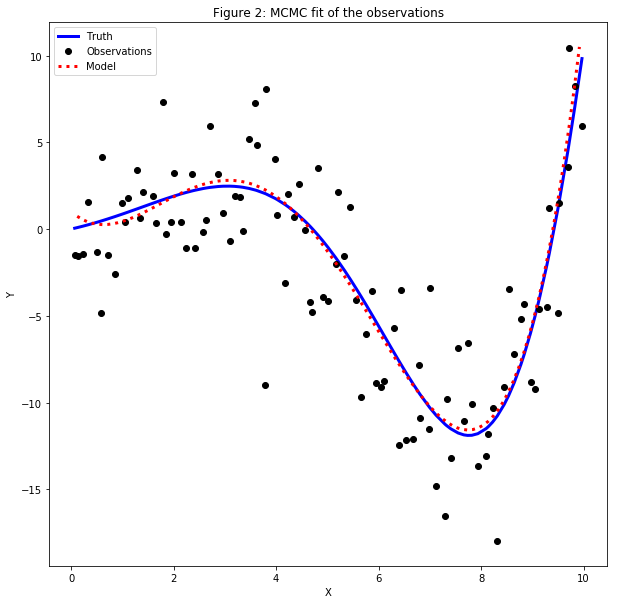

In [7]:
fig = plt.figure(figsize=(10,10))
plt.plot(x, y, 'b-', label = 'Truth',linewidth=3.0)
plt.plot(x, yn, 'ko', label='Observations')
plt.plot(xc, meancurve, 'r:', label = 'Model',linewidth=3.0)
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Figure 2: MCMC fit of the observations')

## Order analysis series

A question we may ask is what order best represents the underlying
function. We can develop some understanding of this by constraining
the maximum allowable order of the fit and observing when the order
histogram converges and/or the mean of the fits converges.

### Setting parameters

We set parameters with lower number of total samples, and also of burnin. We increase the order limit. Then we run the MCMC analysis in a loop in which we increase the order limit of the algorithm at each iteration.

In [8]:
results = []
burnin = 500
total = 3000
orderlimit = 5
for maxorder in range(orderlimit + 1):
    print maxorder
    results.append(rjmcmc.regression_single1d(data, burnin, total, maxorder))

0
1
2
3
4
5


### Plotting the results

Now we plot the data with black crosses the curves from each of the analyses with a different colour

Text(0.5,1,u'Figure 3: MCMC fits with different polynomial orders')

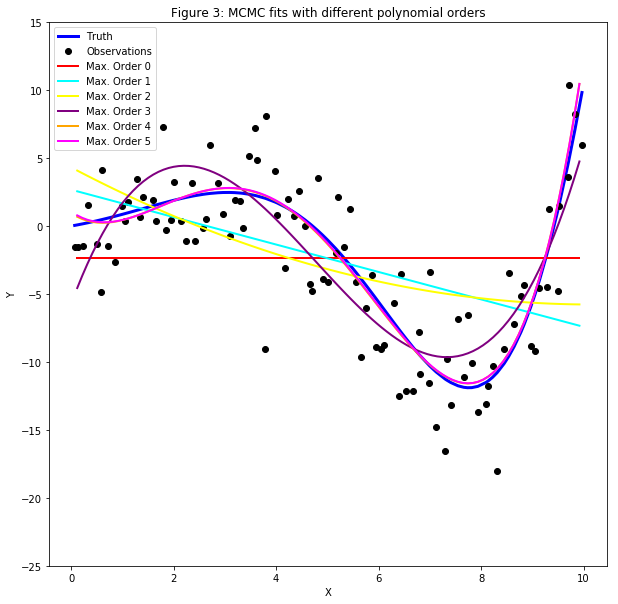

In [9]:
colours=['red','cyan','yellow','purple','orange','magenta']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.plot(x, y, 'b-', label = 'Truth',linewidth=3.0)
ax.plot(x, yn, 'ko', label='Observations')

# Now looping to plot the result of the RJ-MCMC analysis
orders = []
legendtitles = []
for result in results:

    order = result.order_histogram()
    if order == None: # The max order = 0 case will return None so 
        order = [total]

    ax.plot(result.x(), result.mean(), c =colours[len(orders)], label= 'Max. Order %d' % len(orders),linewidth=2.0)

    # Create the order histogram data (append zeros for orders not allowed in the analyses)
    orders.append(order + [0] * (orderlimit + 1 - len(order)))

legend = ax.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.ylim(-25,15)
plt.title('Figure 3: MCMC fits with different polynomial orders')

### Order analysis histogram

Now we can plot a 3D bar chart showing the progression of the order histogram as the analysis maximum order is increased. The order histogram reports the count of polynomials
of each order where the order is randomly choosen from a 
probability distribution determined by the data itself. 

Looking at the figure, it can be seen that when the maximum permitted
order is 0, all the curves sampled are 0th order as expected. As this
maximum order is increased, the distribution of orders changes until
the step from 4 to 5 where there is little difference. It should be
noted that if a tighter noise parameter is used, that this will change
slightly as higher order polynomials will be more favoured to fit the
data better.


Text(0.5,0.92,u'Figure4: Histogram of maximum orders')

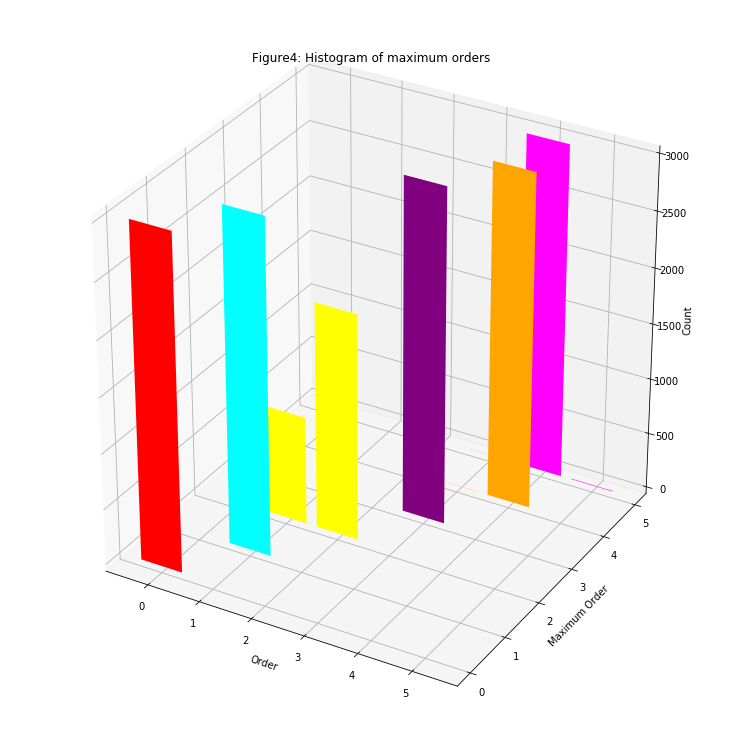

In [10]:
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig)
xs = range(orderlimit + 1)
for maxorder in xs:
    ax.bar(xs, 
           orders[maxorder], 
           zs=maxorder, 
           zdir = 'y', 
           color=colours[maxorder])

ax.set_xlabel('Order')
ax.set_ylabel('Maximum Order')
ax.set_zlabel('Count')
ax.set_title('Figure4: Histogram of maximum orders')

## Confidence Intervals

So far we have only plotted the mean of the fits, however this gives
us no indication of distribution of the fit (this can be thought of as
the confidence of the fit). There are a number of ways in which we can
look at this and one of these is to look at the curves generated
during the analysis.

In this script we call a slightly different function called regression_single1d_sampled which accepts a callback function. We define this function, which accepts an x and y list which is the discretization of the current 
fitting polynomial being used. In this function we sample every
5th polynomial and store them. 

Text(0.5,1,u'Figure 5: Confidence interval (in grey)')

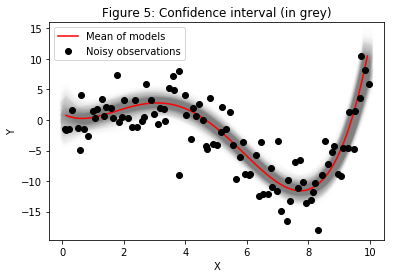

In [11]:
# This is our callback function which samples the curves generated 
# during the analysis
#
sample_x = None
sample_curves = []
sample_i = 0
sample_rate = 5
def sampler_cb(x, y):
    global sample_x, sample_curves, sample_i, sample_rate

    if sample_i == 0:
        sample_x = x

    if sample_i % sample_rate == 0:
        sample_curves.append(y)

    sample_i = sample_i + 1

#
# Run a series of analyses with varying maximum allowed order
#
results = []
burnin = 100
total = 1000
maxorder = 5
results = rjmcmc.regression_single1d_sampled(data, 
                                             sampler_cb,
                                             burnin, 
                                             total, 
                                             maxorder)
    
# Plot the data with black crosses, the sample curves as faint lines, and
# the mean as a red line
#
fig = plt.figure()
ax = fig.add_subplot(111)

yc = 0.5
yalpha = 1.0/((1.0 - yc) * float(len(sample_curves)))
for sy in sample_curves:

    ax.plot(sample_x, sy, 
            color = str(yc),
            alpha = yalpha,
            linestyle = '-',
            linewidth = 10)

ax.plot(results.x(), results.mean(), 'r-',label='Mean of models')
ax.plot(x, yn, 'ko',label='Noisy observations')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.legend()
ax.set_title('Figure 5: Confidence interval (in grey)')



The sampled fits are plotted with transparency so that where they
overlap this will show increased density implying that where these
sampled polynomial ensemble appears darker, we can have higher 
confidence that the underlying function passes through that
region.

### Now let's do the same but as a GIF plot, because it's cool.

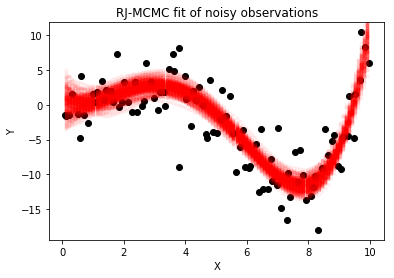

In [12]:
fig_gif = plt.figure()
axg = fig_gif.add_subplot(111)

obs, = axg.plot(x, yn, 'ko')
line, = axg.plot([], [], 'r.',alpha = 0.05)

xdata = []
ydata = []

# initialization function: plot the background of each frame
def init():
    obs.set_data([], [])
    line.set_data([], [])
    return (obs,line,)

def update(i):
    
    xdata.append(sample_x)
    ydata.append(sample_curves[i])
    
    line.set_xdata(xdata)
    line.set_ydata(ydata)
    
    return line

axg.set_xlabel('X')
axg.set_ylabel('Y')
axg.set_title('RJ-MCMC fit of noisy observations')

anim2 = animation.FuncAnimation(fig_gif, update, frames=len(sample_curves), interval=100, repeat=True)
anim2.save('MCMC_example.gif', dpi=80, writer='imagemagick')

## Estimating data noise

With the hierarchical Bayesian approach we include the standard deviation
of the noise on the observations as an unknown. In the above examples
the noise $\sigma$ was set to 3 units, but the actual $\sigma$
of the data noise in Figure 1 is 3.5.
Can we use the data to detect the true standard deviation of its noise?
The hierarchical Bayesian sampling scheme is implemented with the following script. Inference on the noise is implemented by 
introducing a new parameter, $\lambda = \frac{\sigma_{est}}{\sigma_{true}}$, 
defined as the ratio of the estimated noise to the real noise.


Lambda Acceptance Rate (%): 11.0670194004
Lambda average: 0.50661568777


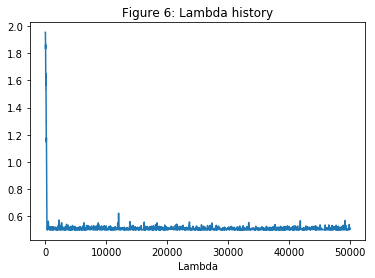

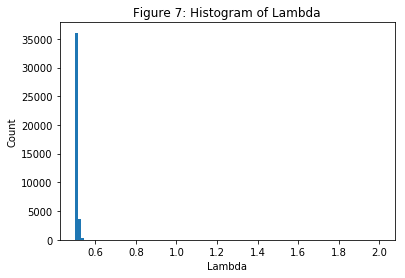

In [13]:
lambda_min = 0.5
lambda_max = 2.0
lambda_std = 0.05


#
# Set the lambda range
#
data.set_lambda_range(lambda_min, lambda_max)
data.set_lambda_std(lambda_std)

#
# Run the default analysis
#
results = rjmcmc.regression_single1d(data)

#
# Retrieve the mean curve for plotting
#
xc = results.x()
meancurve = results.mean()

#
# Retrieve the results of the hierarchical
#
p = results.proposed()
a = results.acceptance()

print 'Lambda Acceptance Rate (%):', float(a[1])/float(p[1]) * 100.0

lh = results.lambda_history()

#
# Plot the hostory of lambda
#

fig = plt.figure()
plt.plot(range(len(lh)), lh)
plt.xlabel('Number of runs')
plt.xlabel('Lambda')
plt.title('Figure 6: Lambda history')

fig = plt.figure()

a = plt.subplot(111)
lsamples = lh[10000:]

n, bins, patches = a.hist(lsamples, 100, range=(lambda_min, lambda_max))
a.set_title('Figure 7: Histogram of Lambda')
a.set_xlabel('Lambda')
a.set_ylabel('Count')

print 'Lambda average:', sum(lsamples)/float(len(lsamples))

In this script we set up a uniform prior on $\lambda$ over a pre-determined range and use
a Gaussian distribution to perturb the $\lambda$ values during the Markov chain.
The range of the values of $\lambda$ as well as the standard deviation of the
perturbation are parameter that must be chosen. These are set in lines
37-42. 

We call the function regression_single1 to do the work. 
We plot the posterior PDF of the noise $\sigma$ as a histogram. 
This plot is shown in Figure 7.

The histogram shows the support of the data for a range of $\lambda$ values. 
Clearly there is information in the data on the likely values of noise.
Where is the peak of the histogram? How does this compare to the ratio of the estimated
to true $\sigma$? Usually the ability of the data to constrain noise parameters will trade-off 
with the model complexity given, in this case, by the order of the polynomial.
You can edit the script by changing the estimated noise and rerun to see what happens.